# Decoy Generation Experiment

Here, we will re-produce the results from [here](file:///C:/Users/kia/Downloads/Metabolomics%20Internship/Papers/Converting%20from%20proteomics%20to%20metabolomics.pdf). In particular, we will produce the QQ-plots of q-values for FDR assessment, and histograms of estimated p-values for null model evaluation.

## Setup

In [138]:
from matchms import Scores, Spectrum, Spikes
from matchms.similarity import CosineGreedy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os

ROOT = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(ROOT, 'Python_Files'))

## Preliminary Functions

In [139]:
from Decoy_Generation_Methods import get_parent_mass

#Preliminary functions required for reproducing results


#Function that produces an array of cosine scores (based on the greedy algorithm from matchms) from reference and query spectra

def scores_array(query_spectra, reference_spectra, mass_tolerance = 1.0, cos_tolerance = 0.1):
    
    cosine_greedy = CosineGreedy(tolerance = cos_tolerance)
    scores = []
    for query in query_spectra:
        
        for reference in reference_spectra:
            
            score = cosine_greedy(query, reference)[0] if parent_mass_match(query, reference, mass_tolerance) else 0
            scores += [cosine_greedy(query, reference)[0]]
    return np.array(scores)

#Function that returns True when two spectra have the same parentmass within a certain tolerance

def parent_mass_match(spectrum_1, spectrum_2, tolerance):
    
    parent_mass_1 = spectrum_1.get("parent_mass") if spectrum_1.get("parent_mass") else get_parent_mass(spectrum_1)
    parent_mass_2 = spectrum_2.get("parent_mass") if spectrum_2.get("parent_mass") else get_parent_mass(spectrum_2)
    if parent_mass_1 == 0 or parent_mass_2 == 0:
        return False
    
    elif abs(parent_mass_1 - parent_mass_2) <= tolerance:
        return True
    
    return False

    

## Import Pre-Processed Dataset "AllPositive"

In [140]:
from matchms.importing import load_from_json

#Import pre-processed dataset



ROOT = os.path.dirname(os.getcwd())
path_data = os.path.join(ROOT, 'Data')
sys.path.insert(0, ROOT)


filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectra = load_from_json(filename)

In [143]:
#No of pre-processed target spectra

print(f'No. of  pre-processed target spectra: {len(spectra)}')

No. of  pre-processed target spectra: 112956


## Post-Process Dataset

In [144]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

from Additional_Post_Processing import window_process
from Additional_Post_Processing import remove_spectra_within_tolerance
from Additional_Post_Processing import remove_spectra_below
from Additional_Post_Processing import remove_spectra_above_intensity

#Post-processing dataset based on spec2vec post-processing and additional post-processing



def post_process_s2v(s):
    
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

def additional_post_process(s):
    
    s = window_process(s, k = 6)
    s = remove_spectra_within_tolerance(s)
    s = remove_spectra_below(s)
    if not s:
        return None
    
    s = remove_spectra_above_intensity(s)
    return s

# apply post processing steps to the data
spectra = [post_process_s2v(s) for s in spectra]
spectra = [additional_post_process(s) for s in spectra if s is not None]

# omit spectrums that didn't qualify for analysis
spectra = [s for s in spectra if s is not None]
target_spectra = spectra

In [145]:
#No. of target spectra remaining after post-processing

print(f'No. of  post-processed target spectra: {len(target_spectra)}')

No. of  post-processed target spectra: 72658


## Creating Query Spectra

### Getting Annotations

In [146]:
Inchikeys = []
for spec in target_spectra:
    Inchikeys.append(spec.get("inchikey"))
    
inchikeys_pd = pd.Series([x for x in Inchikeys if x])
suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= 5])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)

### Randomly select 1000 inchikeys that exist >=5 times in the dataset

In [147]:
num_spectra = 1000

np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]

### Randomly pick one spectra for each of the chosen inchikeys

In [148]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys])       #include all even empty ones to get the IDs right!

np.random.seed(42)                        # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))
    
query_spectra = [target_spectra[i] for i in selected_spectra]

In [149]:
#Remove query spectra from target spectra

target_spectra = [s for i, s in enumerate(target_spectra) if i not in selected_spectra]

print(f'No. of target spectra remaining: {len(target_spectra)}')

No. of target spectra remaining: 71658


## Create Decoys

In [150]:
from Decoy_Generation_Methods import naive_decoys
from Decoy_Generation_Methods import spectrum_based_decoys
from matchms.exporting import save_as_json

#Create decoys based on the naive and spectrum-based method



naive_decoy_spectra = naive_decoys(target_spectra)
spectrum_based_decoy_spectra = spectrum_based_decoys(target_spectra)

#Save decoy spectra

save_as_json(naive_decoy_spectra, "Naive_Decoy_Spectra")
save_as_json(spectrum_based_decoy_spectra, "Spectrum_Based_Decoy_Spectra")

KeyboardInterrupt: 

## FDR Estimation

In [89]:
#Estimating FDRs for 1000 query spectrum for 100 different cosine score thresholds



#quey_spectra is list of query spectra (from target database)
#target_spectra is list of target spectra (target database)
#decoy_spectra is list of decoy spectra (decoy database)
#Assume all necessary processing is done.

score_thresholds = np.arange(0, 1, 0.01)                 #Using 100 score thresholds

#Getting hits for each query spectrum in reference spectra
#Type_query here is whether it's target or decoy hit. True is for target hit, False for decoy hit.

def get_hits(query_spectra, reference_spectra, cos_tolerance, type_hit):
    
    no_query = len(query_spectra)
    hits = pd.DataFrame({'Cosine Score':pd.Series([0]*no_query, dtype='float'), 'Reference InChl':pd.Series([0]*no_query, dtype='str'), 'Reference Id':pd.Series([0]*no_query, dtype='str'), 'Query InChl':pd.Series([0]*no_query, dtype='str'), 'Query Id':pd.Series([0]*no_query, dtype='str'), 'Target/Decoy Hit':pd.Series([0]*no_query, dtype='bool')})
    for i in range(no_query):
    
        query_scores = scores_array([query_spectra[i]], reference_spectra, cos_tolerance = cos_tolerance)
        max_reference = np.argsort(query_scores)[-1]
        reference_inchikey = reference_spectra[max_reference].get("inchikey")
        reference_inchikey = reference_inchikey if reference_inchikey else np.nan
        reference_id = reference_spectra[max_reference].get("spectrumid")
        reference_id = reference_id if reference_id else np.nan
        query_inchikey = query_spectra[i].get("inchikey")           
        query_id = query_spectra[i].get("spectrumid")
        
        hit = [query_scores[max_reference], reference_inchikey, reference_id, query_inchikey, query_id, type_hit]
        hits.iloc[i, :] = hit                 
    return hits

#Estimate FDR from dataframe of sorted hits for certain cosine score threshold
#FDR is estimated as no. decoy hits above threshold/no. target hits above threshold
#Returns np.nan if no. targets is 0

def estimate_FDR(hits, threshold):
    
    thresholds_hits = hits[hits["Cosine Score"] > threshold]
    targets = sum(thresholds_hits["Target/Decoy Hit"] == 1)
    decoys = sum(thresholds_hits["Target/Decoy Hit"] == 0)
    if targets != 0 :
        
        FDR_estimate = decoys/targets
        return FDR_estimate
    else:
        
        print("No targets found. No FDR estimate available.")
        return np.nan
    

#Naive decoy hits

naive_decoy_hits = get_hits(query_spectra, naive_decoy_spectra, cos_tolerance = 0.005, type_hit = False)
target_hits = get_hits(query_spectra, target_spectra, cos_tolerance = 0.005, type_hit = True)
naive_all_hits = pd.concat([naive_decoy_hits, target_hits], ignore_index = True)
naive_all_hits = naive_all_hits.sort_values(by = ["Cosine Score"], ascending= False)

#Spectrum-based decoy hits

spectrum_based_decoy_hits = get_hits(query_spectra, spectrum_based_decoy_spectra, cos_tolerance = 0.005, type_hit = False)
spectrum_based_all_hits = pd.concat([spectrum_based_decoy_hits, target_hits], ignore_index = True)
spectrum_based_all_hits = spectrum_based_all_hits.sort_values(by = ["Cosine Score"], ascending= False)

## Estimating Q-Values

In [125]:
#Estimating q-values for target and decoy hits for query spectra 
#(Using both the naive and spectrum-based method of decoy generartion)



#For the naive method
#Going through each hit from all hits, and find their q-value:
#Go through all the possible score thresholds.
#Calculate their FDRs.
#The min. FDR at which this hit is in the output list is the q-value.

naive_estimated_q_values = []
for index, hit in naive_all_hits.iterrows():
    
    estimate_FDRs = []
    hit_score = hit["Cosine Score"]
    thresholds = score_thresholds[score_thresholds < hit_score]
    for threshold in thresholds:
        
        FDR = estimate_FDR(naive_all_hits, threshold)
        if not np.isnan(FDR):
            
            estimate_FDRs += [FDR]    
    if estimate_FDRs != []:

        naive_estimated_q_values += [min(estimate_FDRs)]
    else:
        
        naive_estimated_q_values += [np.nan]
        
#For the spectrum-based method
#Going through each hit from all hits, and find their q-value:
#Go through all the possible score thresholds.
#Calculate their FDRs.
#The min. FDR at which this hit is in the output list is the q-value.

spectrum_based_estimated_q_values = []
for index, hit in spectrum_based_all_hits.iterrows():
    
    estimate_FDRs = []
    hit_score = hit["Cosine Score"]
    thresholds = score_thresholds[score_thresholds < hit_score]
    for threshold in thresholds:
        
        FDR = estimate_FDR(naive_all_hits, threshold)
        if not np.isnan(FDR):
            
            estimate_FDRs += [FDR]    
    if estimate_FDRs != []:

        spectrum_based_estimated_q_values += [min(estimate_FDRs)]
    else:
        
        spectrum_based_estimated_q_values += [np.nan]

No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets

No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets

## Calculating True FDRs

In [98]:
#Calculating True FDRs


    
#Calculate FDR from dataframe of sorted hits for certain cosine score threshold
#False hits are hits which are not the true identity for associated query spectra
#FDR is estimated as no. false hits/no. target hits above threshold
#Returns np.nan if no. targets is 0

def calculate_FDR(hits, threshold):
    
    thresholds_hits = hits[hits["Cosine Score"] > threshold]
    no_targets = sum(thresholds_hits["Target/Decoy Hit"] == 1)
    target_hits = thresholds_hits[thresholds_hits["Target/Decoy Hit"] == 1]
    no_false_hits = sum(target_hits["Reference InChl"] != target_hits["Query InChl"])
    if no_targets != 0:
        
        FDR = no_false_hits/no_targets
        return FDR
    else:
        
        print("No targets found. No FDR estimate available.")
        return np.nan

## Calculating True Q-Values

In [126]:
#Calculating true q-values for target and decoy hits for query spectra
#(Using both the naive and spectrum-based decoy generation methods)



#For the naive method
#Going through each hit from all hits, and find their true q-value:
#Go through all the possible score thresholds.
#Calculate their true FDRs.
#The min. FDR at which this hit is in the output list is the q-value.

naive_true_q_values = []
for index, hit in naive_all_hits.iterrows():
    
    true_FDRs = []
    hit_score = hit["Cosine Score"]
    thresholds = score_thresholds[score_thresholds < hit_score]
    for threshold in thresholds:
        
        FDR = calculate_FDR(naive_all_hits, threshold)
        if not np.isnan(FDR):
            
            true_FDRs += [FDR]    
    if true_FDRs != []:

        naive_true_q_values += [min(true_FDRs)]
    else:
        
        naive_true_q_values += [np.nan]
        
#For specturm-based method
#Going through each hit from all hits, and find their true q-value:
#Go through all the possible score thresholds.
#Calculate their true FDRs.
#The min. FDR at which this hit is in the output list is the q-value.

spectrum_based_true_q_values = []
for index, hit in spectrum_based_all_hits.iterrows():
    
    true_FDRs = []
    hit_score = hit["Cosine Score"]
    thresholds = score_thresholds[score_thresholds < hit_score]
    for threshold in thresholds:
        
        FDR = calculate_FDR(spectrum_based_all_hits, threshold)
        if not np.isnan(FDR):
            
            true_FDRs += [FDR]    
    if true_FDRs != []:

        spectrum_based_true_q_values += [min(true_FDRs)]
    else:
        
        spectrum_based_true_q_values += [np.nan]

No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets

No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets found. No FDR estimate available.
No targets

## QQ-plots of True Q-Values vs. Esimated Q-Values

In [133]:
#Sorting q-values and removing nas.



#For naive method

naive_estimated_q_values = np.array(naive_estimated_q_values)
naive_true_q_values = np.array(naive_true_q_values)
order = np.argsort(naive_estimated_q_values)
naive_estimated_q_values = naive_estimated_q_values[order]
naive_true_q_values = naive_true_q_values[order]

naive_estimated_non_nans = np.where(~np.isnan(naive_estimated_q_values))[0]
naive_true_non_nans = np.where(~np.isnan(naive_true_q_values))[0]
naive_non_nans = np.intersect1d(naive_estimated_non_nans, naive_true_non_nans, assume_unique = True)
naive_estimated_q_values = naive_estimated_q_values[naive_non_nans]
naive_true_q_values = naive_true_q_values[naive_non_nans]


#For spectrum-based method

spectrum_based_estimated_q_values = np.array(spectrum_based_estimated_q_values)
spectrum_based_true_q_values = np.array(spectrum_based_true_q_values)
order = np.argsort(spectrum_based_estimated_q_values)
spectrum_based_estimated_q_values = spectrum_based_estimated_q_values[order]
spectrum_based_true_q_values = spectrum_based_true_q_values[order]

spectrum_based_estimated_non_nans = np.where(~np.isnan(spectrum_based_estimated_q_values))[0]
spectrum_based_true_non_nans = np.where(~np.isnan(spectrum_based_true_q_values))[0]
spectrum_based_non_nans = np.intersect1d(spectrum_based_estimated_non_nans, spectrum_based_true_non_nans, assume_unique = True)
spectrum_based_estimated_q_values = spectrum_based_estimated_q_values[spectrum_based_non_nans]
spectrum_based_true_q_values = spectrum_based_true_q_values[spectrum_based_non_nans]

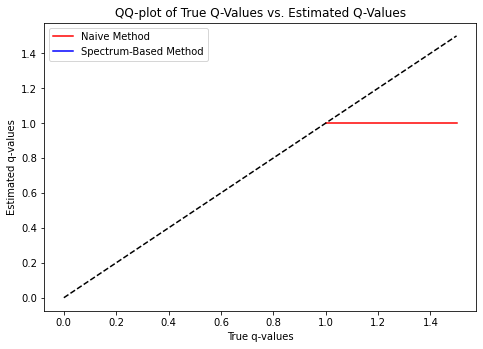

In [134]:
#QQ-plots of true qq-values against estimated q-values.
#For both the naive and spectrum-based methods of decoy generation



#Producing QQ-plot for the two decoy methods.

xmax = np.max(np.concatenate((naive_estimated_q_values, spectrum_based_estimated_q_values)))
ymax = np.max(np.concatenate((naive_true_q_values, spectrum_based_true_q_values)))
ax_lim = xmax if xmax > ymax else ymax 

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
#ax.scatter(naive_true_q_values, naive_estimated_q_values, color = "r", s=20)
#ax.scatter(spectrum_based_true_q_values, spectrum_based_estimated_q_values, color = "b", s=20)
ax.plot(naive_true_q_values, naive_estimated_q_values, color = "r", label = "Naive Method")
ax.plot(spectrum_based_true_q_values, spectrum_based_estimated_q_values, color = "b", label = "Spectrum-Based Method")
ax.plot([0, ax_lim], [0,ax_lim],"r--", color = "black")

#ax.set_xlim(0, ax_lim)
#ax.set_ylim(0, ax_lim)
ax.set_ylabel('Estimated q-values')
ax.set_xlabel('True q-values')
ax.set_title('QQ-plot of True Q-Values vs. Estimated Q-Values')
ax.legend(loc="upper left")
plt.show()